In [1]:
import torch
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import save_image
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from PIL import Image
import shutil
import copy

from torchvision import models
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

!pip install aiogram

import asyncio
from aiogram import Bot, Dispatcher, executor, types
from aiogram.dispatcher import FSMContext
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.contrib.fsm_storage.memory import MemoryStorage
import nest_asyncio
from aiogram.types.message import ContentType


bot = Bot(token="here your token")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = self.gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            G = self.gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

        def gram_matrix(self,input):
            b,c , h, w,  = input.size() 
            features = input.view(c, h*w)  
            G = torch.mm(features, features.t())  
            return G.div( h * w * c*b)
            

class ContentLoss(nn.Module):
        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input


class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std



In [3]:
class TransferModel(nn.Module):
    def __init__(self,content_layers = [ 'conv_2'],
                 style_layers = ['conv_1', 'conv_3','conv_5','conv_9' ,'conv_13'], 
                 num_steps = 1000,
                 content_weight = 1,
                 style_weight = 100000
                 ):
       super().__init__()

       self.content_layers = content_layers
       self.style_layers = style_layers

       self.content_weight = content_weight
       self.style_weight   = style_weight

       self.cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
       self.cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

       self.num_steps = num_steps

    def forward(self,cnn,path, image_size):
        content_image,style_image = self.get_photos(path = path,image_size = image_size)

        input_img = content_image.clone()
        model, style_losses, content_losses = self.get_model_and_losses(cnn,content_image,style_image)
        output_img = self.run_style_transfer(model,input_img, content_losses,style_losses)
        return output_img

    def get_photos(self,path,image_size):
        dir_Style_Content = path
        if os.path.isdir(os.path.join(dir_Style_Content,'.ipynb_checkpoints')) == True:
           os.rmdir(os.path.join(dir_Style_Content,'.ipynb_checkpoints'))
        train_im = ImageFolder(dir_Style_Content , transform = tt.Compose([
                                                                   tt.Resize(image_size),
                                                                   tt.CenterCrop(image_size),
                                                                   tt.ToTensor()]))

        train_im = torch.stack([i[0] for i in train_im])
        content_img = train_im[0].view(1,*train_im[0].shape).to(device)
        style_img   = train_im[1].view(1,*train_im[1].shape).to(device)
        return content_img, style_img

    def get_model_and_losses(self, cnn, content_img,style_img):

        normalization = Normalization(self.cnn_normalization_mean, self.cnn_normalization_std).to(device)
        cnn = copy.deepcopy(cnn)
        content_losses = []
        style_losses = []
        model = nn.Sequential(normalization)

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            model.add_module(name, layer)

            if name in self.content_layers:
              target = model(content_img).detach()
              content_loss = ContentLoss(target)
              model.add_module("content_loss_{}".format(i), content_loss)
              content_losses.append(content_loss)

            if name in self.style_layers:
              target_feature = model(style_img).detach()
              style_loss = StyleLoss(target_feature)
              model.add_module("style_loss_{}".format(i), style_loss)
              style_losses.append(style_loss)        


        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses
         
    def run_style_transfer(self,model,input_img, content_losses, style_losses):
        style_weight = self.style_weight
        content_weight = self.content_weight
 

        optimizer = optim.LBFGS([input_img.requires_grad_()])   
        print('Optimizing..')
        run = [0]
        while run[0] <= self.num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img


In [5]:
print('f')

f


In [4]:
nest_asyncio.apply()
storage = MemoryStorage()
dp = Dispatcher(bot, storage = storage)
class image_type(StatesGroup):
    waiting_image_content = State()
    waiting_image_style = State()

# Здесь есть Небольшой баг. Когда первый раз нажмете запустить у вас не будет отображаться процесс обучения. Это будет выглядеть вот так
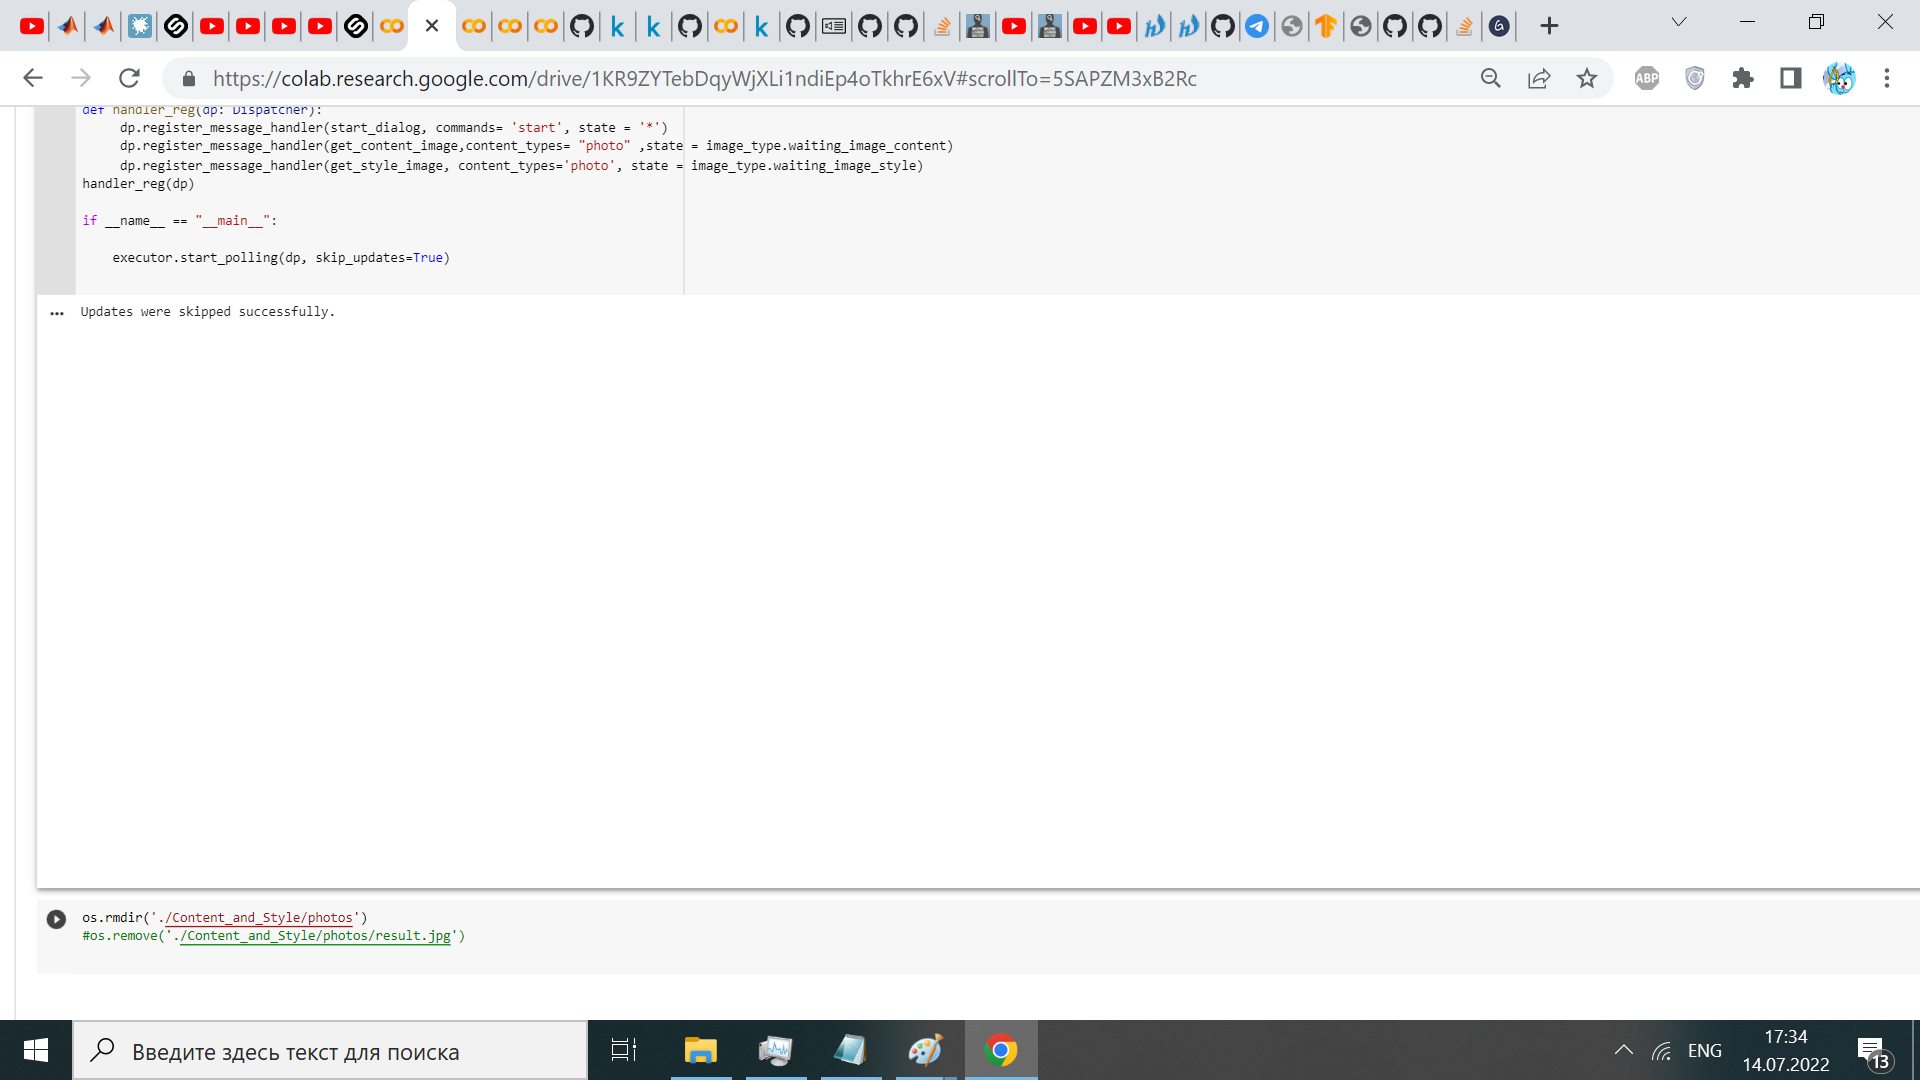

# поэтому рекомендуется перезапустить ячейку, чтобы было вот так. Скорее всего 
#будет сбой, но ничего страшного. Еще раз прокликайте все ячейки и все будет хорошо.
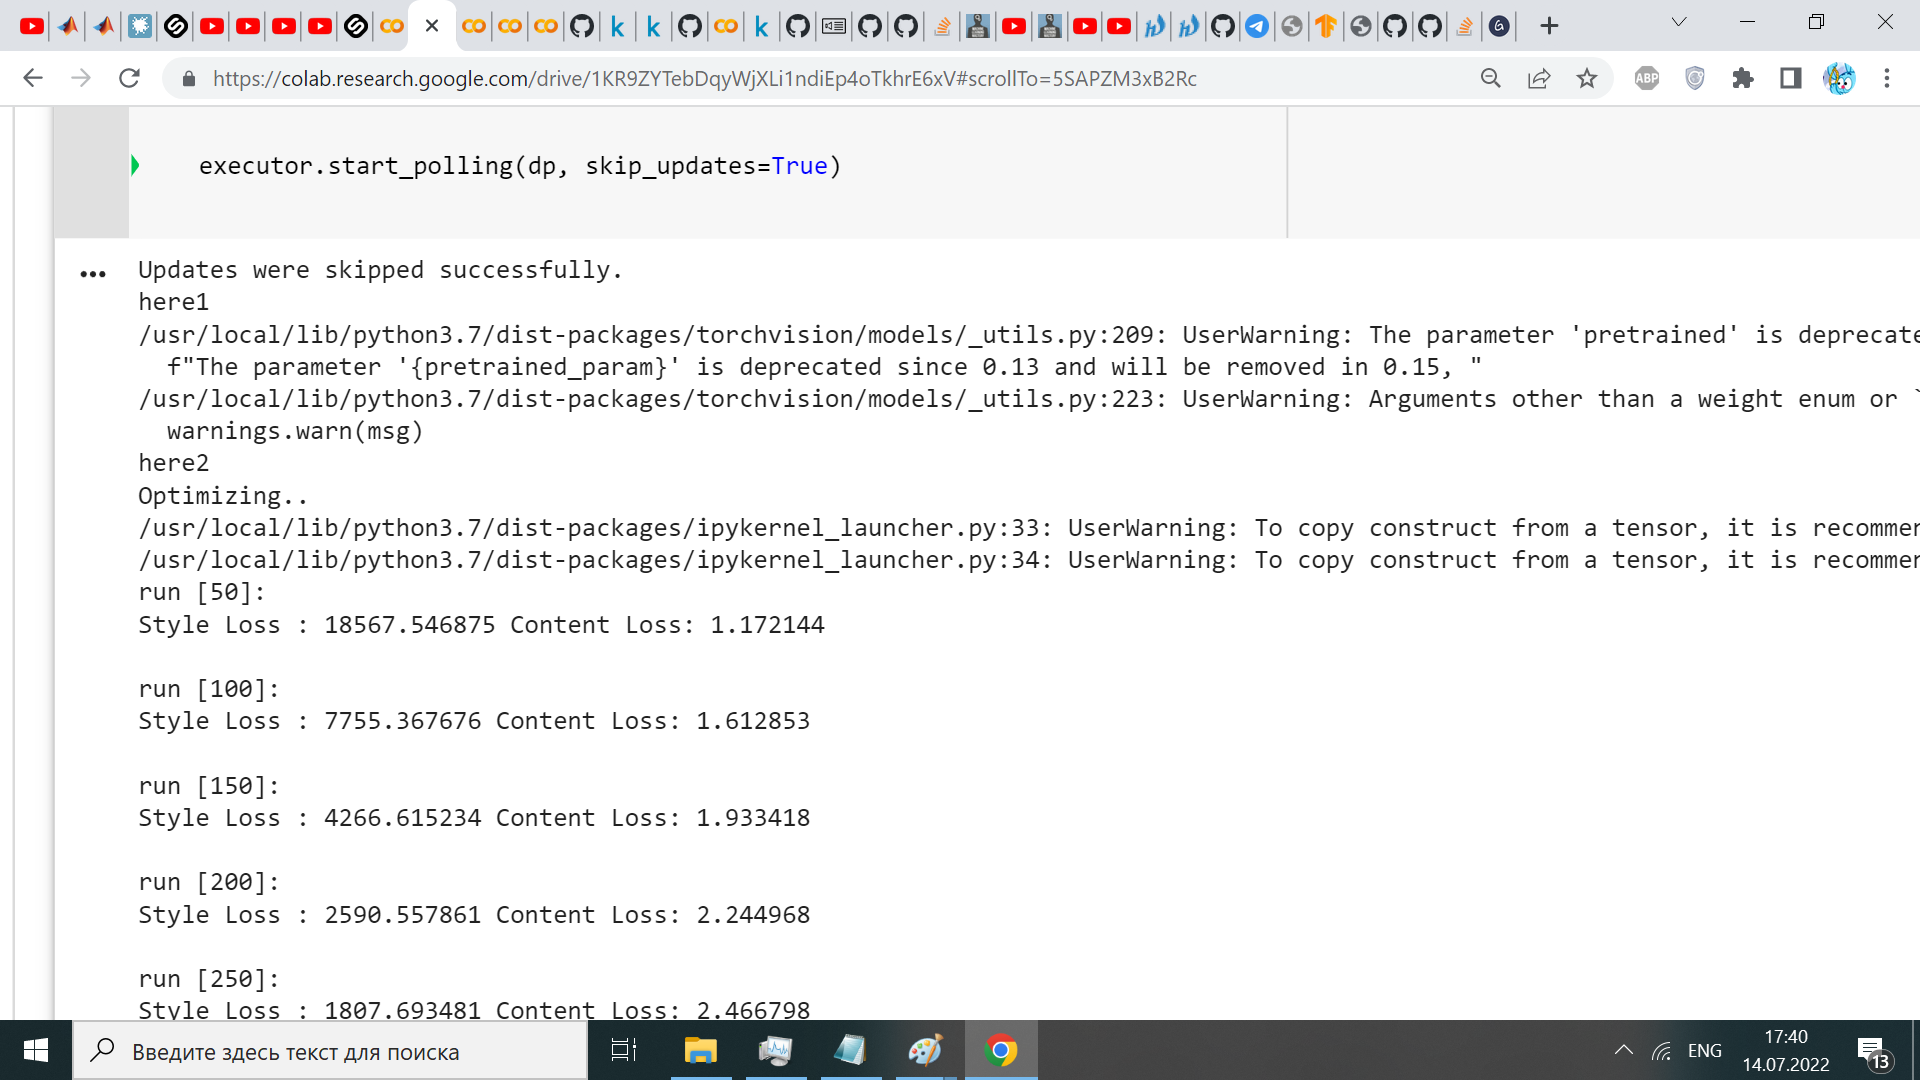

In [5]:




a = 0


#p.message_handler(commands= 'start', state = 'cancel')
async def start_dialog(message: types.Message):
          await message.reply(" Привет."
                               "\n" 
                               "\n Отправьте первую фотографию."
                               "\n Помните: если Вы отправляете "
                               "\n больше 2 изображений за раз,"
                               "\n то учитываться будет первая из,"
                               "\n загруженных")  

          await image_type.waiting_image_content.set()
          await message.answer('Загрузите нужную content-картинку'
                               '(только картинку , без текста, стикеров и т.д.) .'
                               'Я не буду вам отвечать если вы скинете что-то другое.'

                               'Отправляйте файлы как фото.  А не как документ.'
                               'но вы можете начать диалог сначала, если введете команду /start')
          


#@dp.message_handler(content_types= ['photo'],state = '*')
async def get_content_image(message:types.Message,state : FSMContext):
          global a
          if a == 0:
             a+=1
             await message.photo[-1].download(destination_file = "./Content_and_Style/photos/content.jpg")
          else: return


          await message.reply('Выбранная фотография')       
          #await state.update_data(chosen_content = 'content')
          await image_type.next()
          await message.answer('Загрузите нужную style-картинку'
                              '(только картинку , без текста, стикеров и т.д.) .')
          
async def get_style_image(message:types.Message, state:FSMContext):
        
          global a
          if a == 1:
             a+=1
             await message.photo[-1].download(destination_file = "./Content_and_Style/photos/style.jpg")
          else: return


          await message.reply('Выбранная фотография')       
          #await state['style'] = 
          print('here1')
          await message.answer("All fine. Теперь ждите результирующую картинку.")
          model1 = models.vgg16(pretrained = True).features.to(device).eval()
          print('here2')
          result = TransferModel(num_steps = 950,
                                 content_weight = 1,
                                 style_weight=100000000)(model1,'./Content_and_Style/',512)[0]
          plt.figure(figsize = (20,20))
          plt.imshow(make_grid(result).permute(1,2,0).detach().cpu().numpy())
          plt.show() 
          result = transforms.ToPILImage()(result)
          result.save('./Content_and_Style/photos/result.jpg')

          await bot.send_photo(chat_id=message.chat.id,photo = open('./Content_and_Style/photos/result.jpg','rb'))
          a = 0
          os.remove('./Content_and_Style/photos/content.jpg')
          os.remove('./Content_and_Style/photos/style.jpg')
          os.remove('./Content_and_Style/photos/result.jpg')

          await state.finish()


def handler_reg(dp: Dispatcher):
     dp.register_message_handler(start_dialog, commands= 'start', state = '*')
     dp.register_message_handler(get_content_image,content_types= "photo" ,state = image_type.waiting_image_content)
     dp.register_message_handler(get_style_image, content_types='photo', state = image_type.waiting_image_style)
handler_reg(dp)

if __name__ == "__main__":
    
    executor.start_polling(dp, skip_updates=True)
 

Updates were skipped successfully.


here1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

here2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 18749.082031 Content Loss: 1.108523

run [100]:
Style Loss : 8032.003906 Content Loss: 1.569619

run [150]:
Style Loss : 4486.369141 Content Loss: 1.919380

run [200]:
Style Loss : 2670.655518 Content Loss: 2.235951

run [250]:
Style Loss : 1827.780762 Content Loss: 2.465341

run [300]:
Style Loss : 1391.666626 Content Loss: 2.616777

run [350]:
Style Loss : 1120.193359 Content Loss: 2.743455

run [400]:
Style Loss : 936.911072 Content Loss: 2.852736



KeyboardInterrupt: ignored

Cause exception while getting updates.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/aiogram/bot/api.py", line 139, in make_request
    async with session.post(url, data=req, **kwargs) as response:
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/client.py", line 1138, in __aenter__
    self._resp = await self._coro
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/client.py", line 559, in _request
    await resp.start(conn)
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/client_reqrep.py", line 898, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/streams.py", line 616, in read
    await self._waiter
  File "/usr/lib/python3.7/asyncio/futures.py", line 263, in __await__
    yield self  # This tells Task to wait for completion.
  File "/usr/lib/python3.7/asyncio/tasks.py", line 318, in __wakeup
    future.result()
  File "/usr/lib/python3.7/async

In [ ]:
os.rmdir('./Content_and_Style/photos')
#os.remove('./Content_and_Style/photos/result.jpg')
